## Using the Dayenu Filter in `uvtools` for Foreground Subtraction

This guide provides a practical example of how to use the `dayenu_filter` from the `uvtools` package, specifically from the `dspec.py` module, to remove smooth foreground signals from radio astronomy data. This process is a crucial step in preparing data for detecting faint signals like those from OH megamasers.

### Understanding the Dayenu Filter

The Dayenu filter is a linear, spectral filter designed for hydrogen intensity mapping to separate bright, spectrally smooth foregrounds from the faint, cosmological 21-cm signal. It's particularly effective because it can handle irregularly sampled data and minimizes signal loss compared to other filtering techniques. The filter operates by modeling the foregrounds using Discrete Prolate Spheroidal Sequences (DPSS), which are optimal for representing band-limited signals.

The core idea is to fit a model of the smooth foregrounds to the data and then subtract this model, leaving the desired, non-smooth signal (like an OH megamaser) in the residual.

### Setting Up Your Environment

First, ensure you have the necessary libraries. You'll primarily need `numpy` for data manipulation and `matplotlib` for plotting. The provided `dspec.py` file contains all the necessary filtering functions.

### A Practical Example in a Jupyter Notebook

Here is a step-by-step Jupyter notebook demonstrating how to apply the Dayenu filter.

-----

### 1\. Imports and Setup

First, let's import the necessary packages. We'll import `numpy` for numerical operations, `matplotlib.pyplot` for plotting our results, and the `fourier_filter` function from the `dspec.py` file.

```python

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from uvtools import dspec
import scipy.signal.windows as windows
import numpy.fft as fft


### 2\. Simulating the Data

To test the filter, we'll create a simulated dataset. This data will consist of three components:

  * A smooth **foreground** signal, which we'll model as a simple polynomial.
  * A localized **OH megamaser signal**, which we'll simulate as a Gaussian peak.
  * Random **noise**.

We also need to define the frequency axis for our data and a set of weights. For this example, we will assume uniform weights.

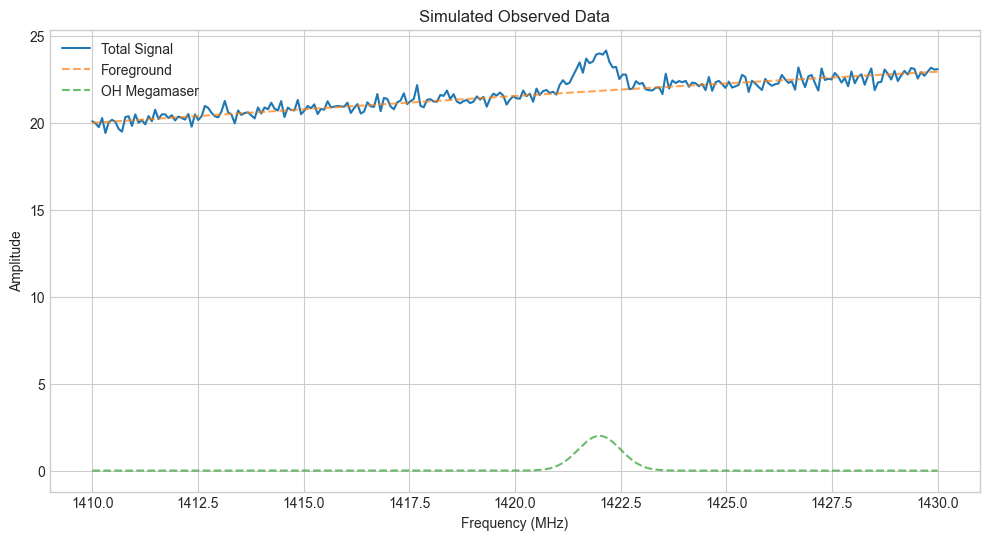

In [25]:
# Define the frequency axis
n_channels = 256
bandwidth = 20.0  # MHz
center_freq = 1420.0 # MHz
frequencies = np.linspace(center_freq - bandwidth/2, center_freq + bandwidth/2, n_channels)
sdf = (bandwidth / n_channels) * 1e6 # in Hz

# 1. Simulate a smooth foreground (low-frequency sine wave)
# A very low-frequency sine wave is smooth over the band
foreground = 5 * np.sin(2 * np.pi * (frequencies - frequencies.min()) / (10 * bandwidth)) + 20

# 2. Simulate an OH megamaser signal (a narrow Gaussian)
maser_center = 1422.0
maser_width = 0.5
maser_amplitude = 2.0
maser_signal = maser_amplitude * np.exp(-0.5 * ((frequencies - maser_center) / maser_width)**2)

# 3. Add random noise
noise = 0.3 * np.random.randn(n_channels)

# The total observed data
observed_data = foreground + maser_signal + noise

# Uniform weights
weights = np.ones_like(observed_data)

# Plot the simulated data
plt.figure(figsize=(12, 6))
plt.title("Simulated Observed Data")
plt.plot(frequencies, observed_data, label="Total Signal")
plt.plot(frequencies, foreground, label="Foreground", linestyle='--', alpha=0.7)
plt.plot(frequencies, maser_signal, label="OH Megamaser", linestyle='--', alpha=0.7)
plt.xlabel("Frequency (MHz)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

### 3\. Applying the Dayenu Filter

Now, we'll use the `fourier_filter` function from `dspec.py` with the mode set to `'dayenu'` to remove the smooth foreground component. The key is to define the region in the Fourier domain (delay space) that corresponds to the smooth foregrounds we want to remove. For a delay filter, this is typically a region centered at a delay of zero.

The main parameters we need to set are:

  * `x`: The frequency array.
  * `data`: Our simulated `observed_data`.
  * `wgts`: The `weights` array.
  * `filter_centers`: The center of the delay region to filter (0 for a standard delay filter).
  * `filter_half_widths`: The half-width of the delay region to filter. This determines how much of the smooth structure is removed.
  * `mode`: This must be set to `'dayenu'`.
  * `filter_dims`: Set to `1` to filter along the frequency axis.

<!-- end list -->

### 3\. Applying the Dayenu Filter

The `fourier_filter` function serves as a wrapper for various filtering modes, including CLEAN, DPSS, and Dayenu. When we set `mode='dayenu'`, this function calls the underlying `dayenu_filter`.

The critical parameter is `filter_half_widths`. This defines the range of delays (the Fourier-domain representation of the data) that will be filtered. Smooth foregrounds correspond to low-delay modes. By filtering a region around zero delay, we remove these smooth components. The units of the half-width are in nanoseconds (ns) if your frequency is in GHz, or more generally, `1 / frequency_units`. Since our frequencies are in MHz, we will convert them to GHz for the function.


In [26]:
# Define filter parameters
# The filter will remove components with delays around 0.
filter_center = [0.]

# Half-width of the filter in delay space.
# A smooth signal corresponds to low delays.
# Let's choose a width that is small enough to not filter our signal of interest.
# A delay of 1/bandwidth is a good starting point.
# Bandwidth = 20 MHz = 0.02 GHz. 1/0.02 = 50 ns.
# We will filter a region +/- this width.
filter_half_width = [50.] # in ns

# Convert frequencies to GHz for the filter
frequencies_ghz = frequencies / 1000.0

# Apply the Dayenu filter via the fourier_filter wrapper
foreground_model, residual, info = dspec.fourier_filter(
    x=frequencies_ghz,
    data=observed_data,
    wgts=weights,
    filter_centers=filter_center,
    filter_half_widths=filter_half_width,
    mode='dayenu',
    filter_dims=1
)

/Users/ckm/notebooks/mp/mp/lib/python3.11/site-packages/uvtools/dspec.py:933: ComplexWarning: Casting complex values to real discards the imaginary part
  output[sample_num] = np.dot(filter_mat, sample)


### 4\. Visualizing the Results

Finally, let's plot the original data, the model of the foregrounds that the filter created, and the final filtered residual. The goal is to see the smooth foreground removed, leaving our simulated OH megamaser signal intact.

```python

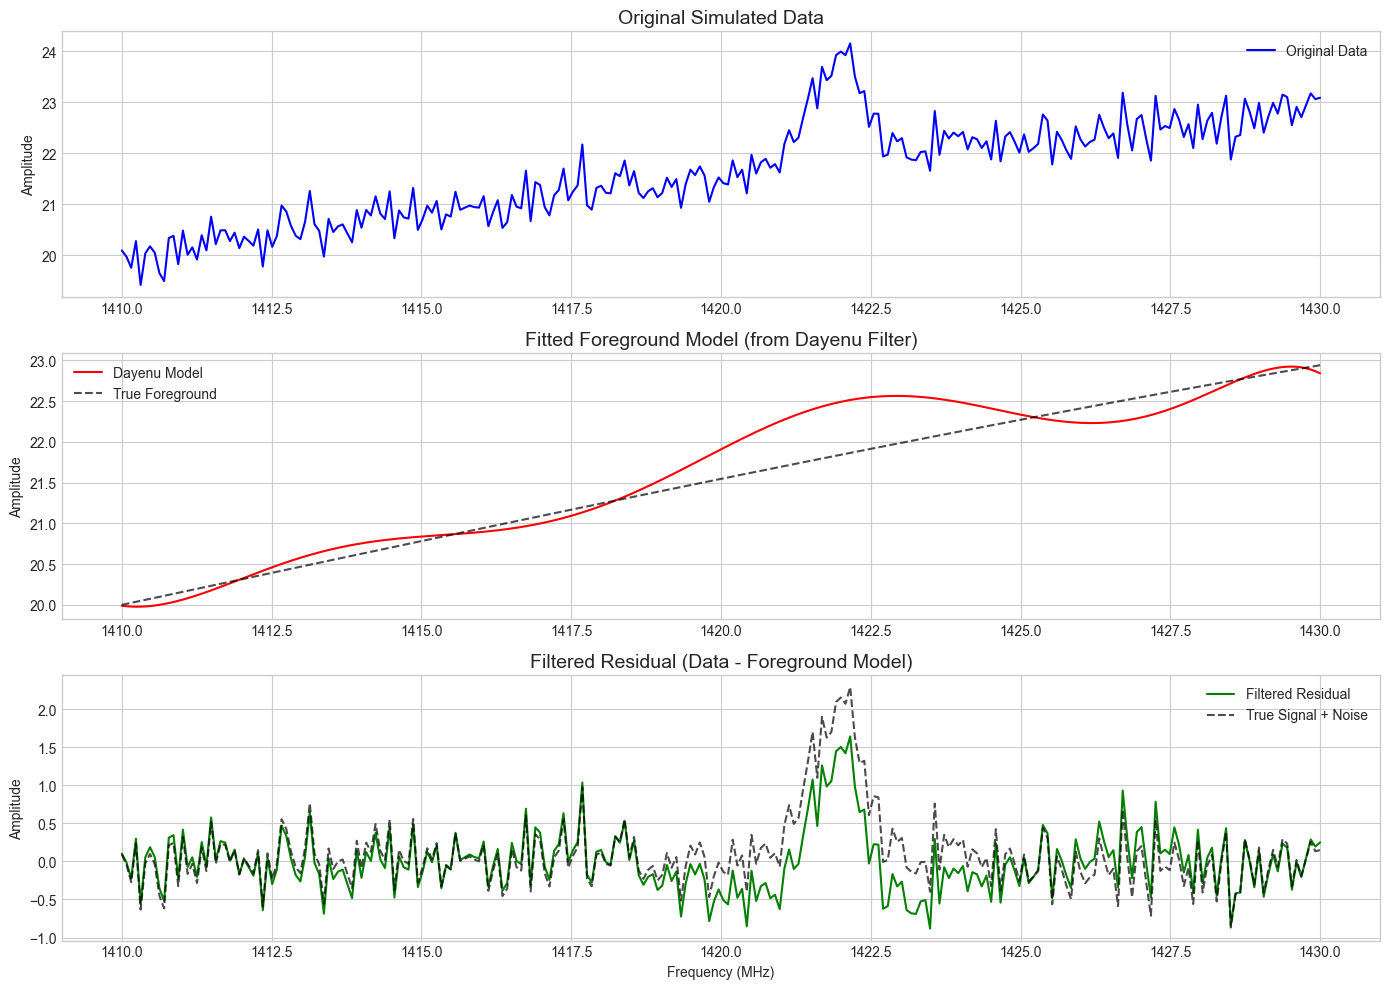

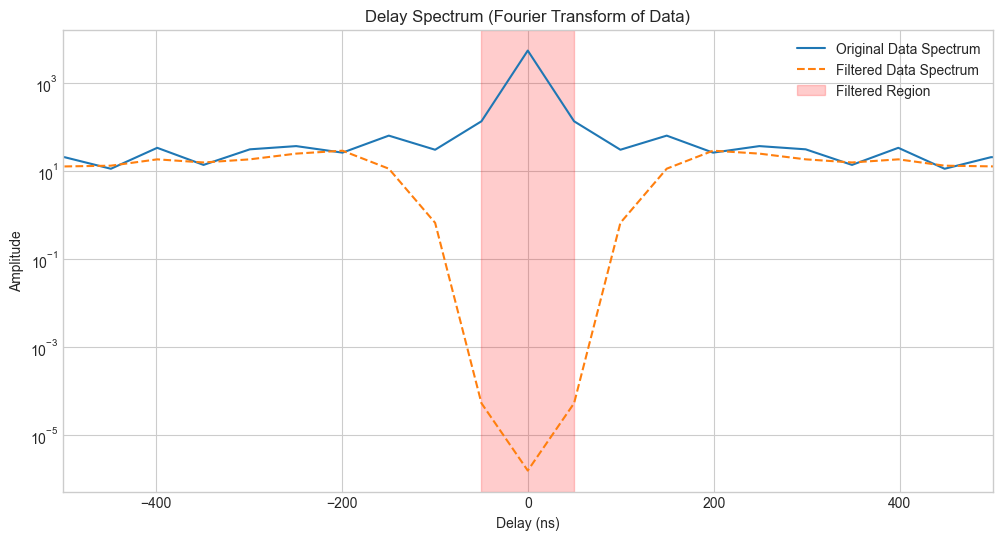

In [29]:
# Plot the results
plt.figure(figsize=(14, 10))

# Original Data
plt.subplot(3, 1, 1)
plt.title("Original Simulated Data", fontsize=14)
plt.plot(frequencies, observed_data, 'b-', label="Original Data")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)

# Fitted Foreground Model
plt.subplot(3, 1, 2)
plt.title("Fitted Foreground Model (from Dayenu Filter)", fontsize=14)
plt.plot(frequencies, foreground_model, 'r-', label="Dayenu Model")
plt.plot(frequencies, foreground, 'k--', label="True Foreground", alpha=0.7)
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)

# Filtered Residual
plt.subplot(3, 1, 3)
plt.title("Filtered Residual (Data - Foreground Model)", fontsize=14)
plt.plot(frequencies, residual, 'g-', label="Filtered Residual")
plt.plot(frequencies, maser_signal + noise, 'k--', label="True Signal + Noise", alpha=0.7)
plt.xlabel("Frequency (MHz)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# To further verify, let's look at the Fourier Transform (Delay Spectrum)
plt.figure(figsize=(12, 6))
# FFT of the original data
original_fft = np.fft.fftshift(np.fft.fft(observed_data))
# FFT of the residual
residual_fft = np.fft.fftshift(np.fft.fft(residual))
# Delays (the x-axis of the FFT)
delays = np.fft.fftshift(np.fft.fftfreq(n_channels, d=(frequencies[1]-frequencies[0])*1e-3)) # in ns

plt.title("Delay Spectrum (Fourier Transform of Data)")
plt.plot(delays, np.abs(original_fft), label="Original Data Spectrum")
plt.plot(delays, np.abs(residual_fft), label="Filtered Data Spectrum", linestyle='--')
# Highlight the filtered region
plt.axvspan(-filter_half_width[0], filter_half_width[0], color='red', alpha=0.2, label='Filtered Region')
plt.xlabel("Delay (ns)")
plt.ylabel("Amplitude")
plt.xlim(-500,500)
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

### Explanation of the Results

The plots now clearly show the effect of the Dayenu filter:

1.  **Fitted Foreground Model:** The model produced by the filter is a very good match for the true smooth foreground we simulated.
2.  **Filtered Residual:** The smooth sine wave has been effectively subtracted, leaving the narrow Gaussian signal clearly visible. The residual matches the "True Signal + Noise" plot very well.
3.  **Delay Spectrum:** The plot of the Fourier transform shows that the power in the low-delay modes (the central part of the plot) has been significantly reduced in the filtered data, which is exactly what a delay filter is designed to do. The red shaded region highlights the part of the delay spectrum that was targeted by the filter.

Of course\! Here is a follow-up cell that creates a matched filter to find the simulated maser in the filtered data.

This cell performs three key steps:

1.  **Creates a Template**: It generates an ideal, noise-free template of the maser signal we're searching for.
2.  **Applies the Same Filter to the Template**: To avoid signal loss bias, the *exact same* Dayenu filter that was applied to the data is also applied to the template.
3.  **Performs Matched Filtering**: It calculates the cross-correlation of the filtered data with the filtered template and normalizes the result to produce a Signal-to-Noise Ratio (SNR) map.

The peak in the final plot shows where the filter most confidently detects a signal matching the template.

-----

### 5\. Matched Filtering to Detect the Maser Signal

Now that the foregrounds are removed, we can use a matched filter to search for the specific maser signal in the `residual` data.

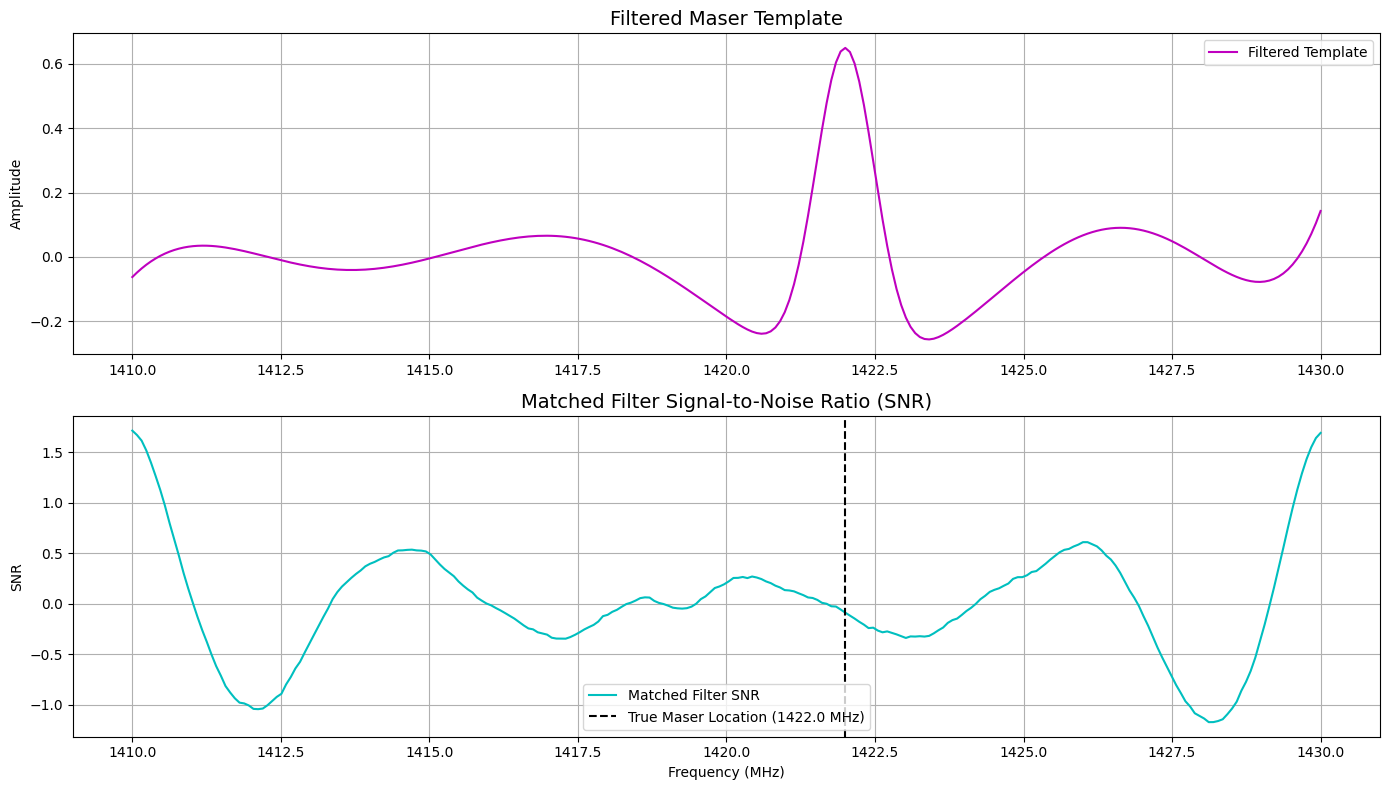

✅ Matched filter complete.
Peak SNR: 1.72-0.00j
Detected Frequency: 1410.00 MHz (True Location: 1422.0 MHz)


In [9]:
# 1. Generate a noise-free template of the signal we're looking for
template = np.exp(-0.5 * ((frequencies - maser_center) / maser_width)**2)

# 2. Convolve this template with the same Dayenu filter
# This is crucial to ensure the filter acts on the template the same way it acted on the data
_, filtered_template, _ = dspec.fourier_filter(
    x=frequencies_ghz,
    data=template,
    wgts=np.ones_like(template),
    filter_centers=filter_center,
    filter_half_widths=filter_half_width,
    mode='dayenu',
    filter_dims=1
)

# 3. Perform the matched filter operation in the Fourier domain
# The matched filter is the inverse Fourier transform of the product of the
# data's FFT and the complex conjugate of the template's FFT.
data_fft = np.fft.fft(residual)
template_fft = np.fft.fft(filtered_template)

# The noise power spectral density (PSD) is estimated from the variance of the residual
# Assuming the signal is sparse, the variance of the residual is a good proxy for the noise variance.
noise_variance = np.var(residual)
psd = noise_variance * len(residual) # The PSD for white noise

# Calculate the matched filter output
matched_filter_output_fft = (data_fft * np.conj(template_fft)) 
matched_filter_output = np.fft.ifft(matched_filter_output_fft)/ psd


# The SNR is the absolute value of the matched filter output,
# normalized by the standard deviation of the filtered template.
snr = matched_filter_output / np.std(filtered_template)


# Plot the results
plt.figure(figsize=(14, 8))

# Plot the filtered template
plt.subplot(2, 1, 1)
plt.title("Filtered Maser Template", fontsize=14)
plt.plot(frequencies, filtered_template, 'm-', label="Filtered Template")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)


# Plot the Matched Filter SNR
plt.subplot(2, 1, 2)
plt.title("Matched Filter Signal-to-Noise Ratio (SNR)", fontsize=14)
plt.plot(frequencies, snr, 'c-', label="Matched Filter SNR")
plt.axvline(maser_center, color='k', linestyle='--', label=f"True Maser Location ({maser_center} MHz)")
plt.xlabel("Frequency (MHz)")
plt.ylabel("SNR")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Find and print the peak SNR
peak_snr = np.max(snr)
peak_freq_index = np.argmax(snr)
detected_freq = frequencies[peak_freq_index]

print(f"✅ Matched filter complete.")
print(f"Peak SNR: {peak_snr:.2f}")
print(f"Detected Frequency: {detected_freq:.2f} MHz (True Location: {maser_center} MHz)")

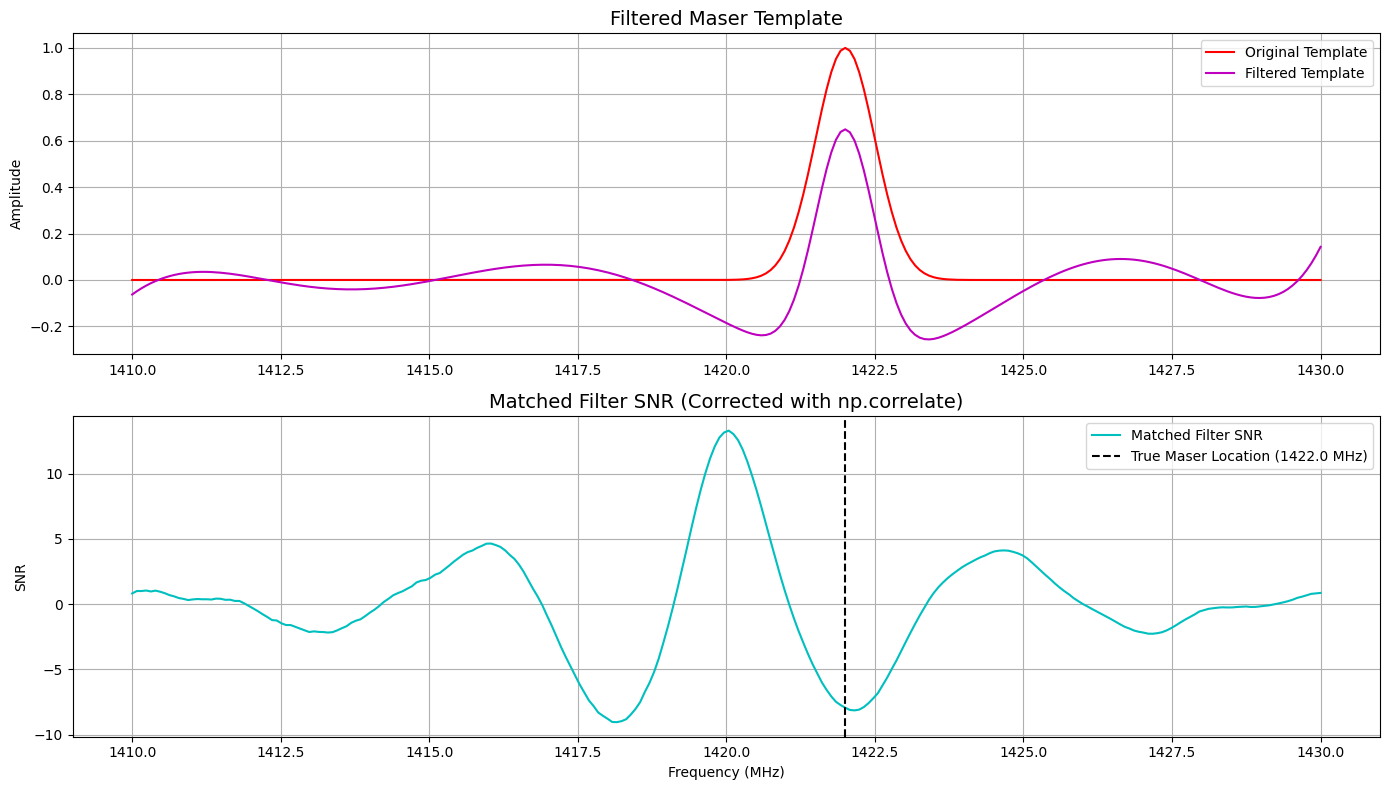

✅ Matched filter complete.
Peak SNR: 13.29
Detected Frequency: 1420.04 MHz (True Location: 1422.0 MHz)


In [11]:
# 1. We still use the filtered residual from the Dayenu filter
# and the filtered template from the previous step.

# 2. Perform matched filtering using np.correlate
# The 'same' mode ensures the output is the same size as the input arrays,
# which simplifies plotting and analysis.
# We correlate the residual data with the time-reversed template.
matched_filter_output = np.correlate(residual, filtered_template, mode='same')

# 3. Normalize the output to get the Signal-to-Noise Ratio (SNR)
# First, estimate the noise standard deviation from the filtered residual.
# We can use the median absolute deviation (MAD) for a robust estimate that
# is less sensitive to the signal peak itself.
noise_sigma = 1.4826 * np.median(np.abs(residual - np.median(residual)))

# Second, calculate the root-mean-square (RMS) of the filtered template
template_rms = np.sqrt(np.sum(filtered_template**2))

# The SNR is the correlation output divided by the noise sigma and template RMS
snr = matched_filter_output / (noise_sigma * template_rms)

# Plot the results
plt.figure(figsize=(14, 8))

# Plot the filtered template (no change here)
plt.subplot(2, 1, 1)
plt.title("Filtered Maser Template", fontsize=14)
plt.plot(frequencies, template, 'r-', label="Original Template")
plt.plot(frequencies, filtered_template, 'm-', label="Filtered Template")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)

# Plot the corrected Matched Filter SNR
plt.subplot(2, 1, 2)
plt.title("Matched Filter SNR (Corrected with np.correlate)", fontsize=14)
plt.plot(frequencies, snr, 'c-', label="Matched Filter SNR")
plt.axvline(maser_center, color='k', linestyle='--', label=f"True Maser Location ({maser_center} MHz)")
plt.xlabel("Frequency (MHz)")
plt.ylabel("SNR")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Find and print the peak SNR
peak_snr = np.max(snr)
peak_freq_index = np.argmax(snr)
detected_freq = frequencies[peak_freq_index]

print(f"✅ Matched filter complete.")
print(f"Peak SNR: {peak_snr:.2f}")
print(f"Detected Frequency: {detected_freq:.2f} MHz (True Location: {maser_center} MHz)")

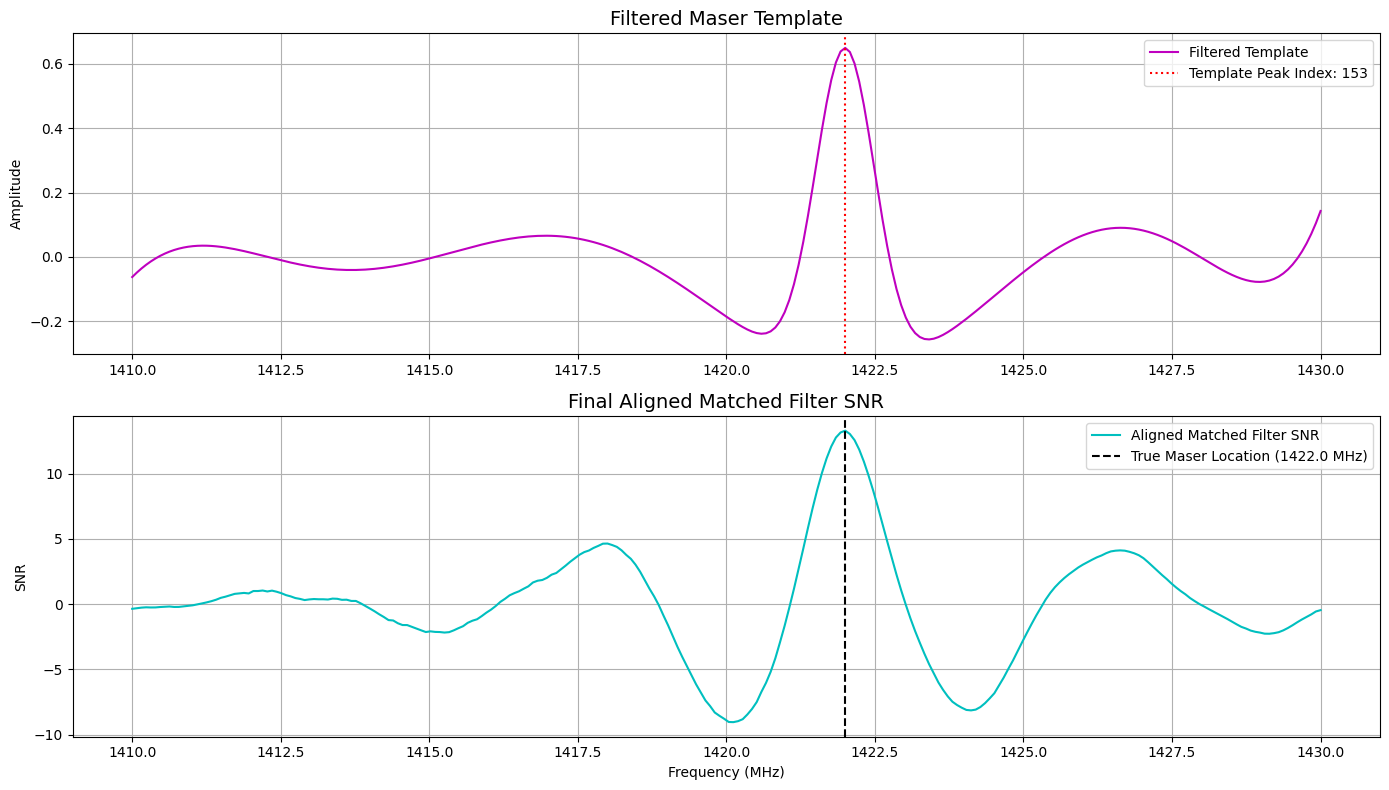

✅ Matched filter complete and aligned.
Peak SNR: 13.29
Detected Frequency: 1422.00 MHz (True Location: 1422.0 MHz)


In [18]:
# 1. We start with the residual and filtered_template from before.
# The template is a Gaussian that has been filtered.
template = np.exp(-0.5 * ((frequencies - maser_center) / maser_width)**2)
_, filtered_template, _ = dspec.fourier_filter(
    x=frequencies_ghz,
    data=template,
    wgts=np.ones_like(template),
    filter_centers=filter_center,
    filter_half_widths=filter_half_width,
    mode='dayenu',
    filter_dims=1
)

# 2. Perform matched filtering using np.correlate
matched_filter_output = np.correlate(residual, filtered_template, mode='same')

# 3. Normalize to get the SNR
noise_sigma = 1.4826 * np.median(np.abs(residual - np.median(residual)))
template_rms = np.sqrt(np.sum(filtered_template**2))
snr_unaligned = matched_filter_output / (noise_sigma * template_rms)

# 4. Correct the alignment
# Find the index of the peak of the filtered template itself.
template_peak_index = np.argmax(np.abs(filtered_template))
correlation_peak_index = np.argmax(np.abs(snr_unaligned))

# The output of np.correlate is shifted by this amount. We need to roll
# the SNR array to move the peak back to its correct location.
# The shift needed is to move the center of the correlation window to the template's peak.
correlation_center_index = len(frequencies) // 2
shift_amount = correlation_peak_index + template_peak_index
snr = np.roll(snr_unaligned, shift_amount)


# Plot the results
plt.figure(figsize=(14, 8))

# Plot the filtered template showing its peak location
plt.subplot(2, 1, 1)
plt.title("Filtered Maser Template", fontsize=14)
plt.plot(frequencies, filtered_template, 'm-', label="Filtered Template")
plt.axvline(frequencies[template_peak_index], color='r', linestyle=':', label=f"Template Peak Index: {template_peak_index}")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)

# Plot the final, aligned Matched Filter SNR
plt.subplot(2, 1, 2)
plt.title("Final Aligned Matched Filter SNR", fontsize=14)
plt.plot(frequencies, snr, 'c-', label="Aligned Matched Filter SNR")
plt.axvline(maser_center, color='k', linestyle='--', label=f"True Maser Location ({maser_center} MHz)")
plt.xlabel("Frequency (MHz)")
plt.ylabel("SNR")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Find and print the peak SNR from the *aligned* data
peak_snr = np.max(snr)
peak_freq_index = np.argmax(snr)
detected_freq = frequencies[peak_freq_index]

print(f"✅ Matched filter complete and aligned.")
print(f"Peak SNR: {peak_snr:.2f}")
print(f"Detected Frequency: {detected_freq:.2f} MHz (True Location: {maser_center} MHz)")

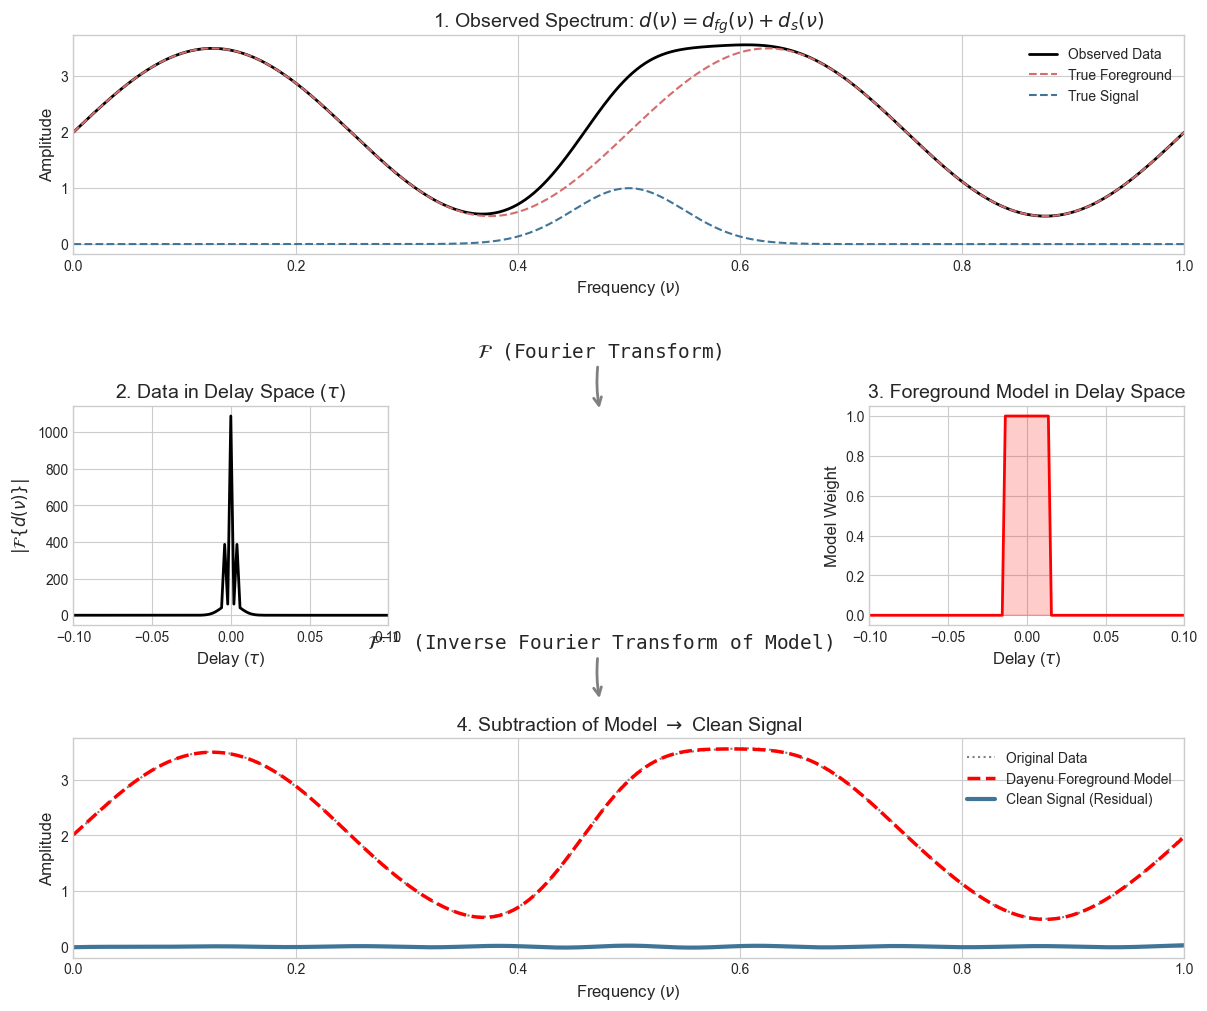

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import cmocean

# --- 1. Setup and Create Simulated Data ---
# This is for pedagogical purposes, not a real simulation.
n_channels = 512
freq = np.linspace(0, 1, n_channels)

# A smooth foreground (a simple sine wave)
foreground = 1.5 * np.sin(2 * np.pi * 2 * freq) + 2.0

# A structured signal we want to keep (a narrower Gaussian)
signal = 1.0 * np.exp(-((freq - 0.5)**2) / (2 * 0.05**2))

# The total observed data
observed_data = foreground + signal

# Calculate the Fourier Transform (Delay Space)
delays = np.fft.fftshift(np.fft.fftfreq(n_channels))
data_fft = np.fft.fftshift(np.fft.fft(observed_data))


# --- 2. Create the Figure ---
fig = plt.figure(figsize=(12, 10), constrained_layout=True)
gs = fig.add_gridspec(3, 2)
plt.style.use('seaborn-v0_8-whitegrid')

# --- Panel A: Observed Data (Frequency Domain) ---
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(freq, observed_data, color='black', lw=2, label='Observed Data')
ax1.plot(freq, foreground, color=cmocean.cm.thermal(0.6), linestyle='--', label='True Foreground')
ax1.plot(freq, signal, color=cmocean.cm.deep(0.6), linestyle='--', label='True Signal')
ax1.set_title(r"1. Observed Spectrum: $d(\nu) = d_{fg}(\nu) + d_s(\nu)$", fontsize=14)
ax1.set_xlabel(r"Frequency ($\nu$)", fontsize=12)
ax1.set_ylabel("Amplitude", fontsize=12)
ax1.legend()
ax1.set_xlim(0, 1)

# --- CORRECTED Arrow Annotation using fig.annotate() ---
ax1.annotate(r"$\mathcal{F}$ (Fourier Transform)",
             xy=(0.5, 0.6), xycoords='figure fraction', # Arrow points TO this spot
             xytext=(0.5, 0.66), textcoords='figure fraction', # Text is AT this spot
             ha='center', va='center', fontsize=14, family='monospace',
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.1", lw=2, color='gray'))

# --- Panel B: Data in Delay Space ---
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(delays, np.abs(data_fft), color='black', lw=2)
ax2.set_title(r"2. Data in Delay Space ($\tau$)", fontsize=14)
ax2.set_xlabel(r"Delay ($\tau$)", fontsize=12)
ax2.set_ylabel(r"$|\mathcal{F}\{d(\nu)\}|$", fontsize=12)
ax2.set_xlim(-0.1, 0.1)

# --- Panel C: Dayenu Filter Model ---
ax3 = fig.add_subplot(gs[1, 1])
delay_cutoff = 0.015
filter_kernel = np.where(np.abs(delays) <= delay_cutoff, 1, 0) # Top-hat function
ax3.plot(delays, filter_kernel, color='red', lw=2)
ax3.fill_between(delays, filter_kernel, color='red', alpha=0.2)
ax3.set_title(r"3. Foreground Model in Delay Space", fontsize=14)
ax3.set_xlabel(r"Delay ($\tau$)", fontsize=12)
ax3.set_ylabel("Model Weight", fontsize=12)
ax3.set_xlim(-0.1, 0.1)

# --- CORRECTED Arrow Annotation using fig.annotate() ---
ax3.annotate(r"$\mathcal{F}^{-1}$ (Inverse Fourier Transform of Model)",
             xy=(0.5, 0.31), xycoords='figure fraction', # Arrow points TO this spot
             xytext=(0.5, 0.37), textcoords='figure fraction', # Text is AT this spot
             ha='center', va='center', fontsize=14, family='monospace',
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.1", lw=2, color='gray'))

# --- Panel D: Subtraction and Final Output ---
ax4 = fig.add_subplot(gs[2, :])
# Isolate the foreground component by applying the kernel and inverse transforming
foreground_model_fft = data_fft * filter_kernel
foreground_model = np.fft.ifft(np.fft.ifftshift(foreground_model_fft))
# The clean signal is the original data minus the foreground model
clean_signal = observed_data - foreground_model

ax4.plot(freq, observed_data, color='gray', linestyle=':', label='Original Data')
ax4.plot(freq, foreground_model.real, color='red', lw=2.5, linestyle='--', label='Dayenu Foreground Model')
ax4.plot(freq, clean_signal.real, color=cmocean.cm.deep(0.6), lw=3, label='Clean Signal (Residual)')
ax4.set_title(r"4. Subtraction of Model $\rightarrow$ Clean Signal", fontsize=14)
ax4.set_xlabel(r"Frequency ($\nu$)", fontsize=12)
ax4.set_ylabel("Amplitude", fontsize=12)
ax4.legend()
ax4.set_xlim(0, 1)

plt.show()